<a href="https://colab.research.google.com/github/Rafiy27/Tugas-Akhir-Hate-Speech/blob/main/Copy_of_TA_Model_(Tanpa_GA)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Library

In [1]:
!pip install pandas openpyxl fasttext tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 470.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199774 sha256=fd50f917b3d09f657e9405d7b3351ff9d4bc4a3ea88eca83f8820a5937e62cca
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


# Import Dataset

In [2]:
import pandas as pd

df = pd.read_excel("datasetTA (1).xlsx")
df.columns

Index(['Unnamed: 0', 'full_text', 'Label_Final', 'Tweet_Stemmed'], dtype='object')

In [3]:
data = df['full_text']
labels = df['Label_Final']

# Pre Processing Data

## Data Cleaning

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Menghapus tautan
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Menghapus emoji
    return text.lower().strip()

data = data.apply(clean_text)

## Case Folding

In [ ]:
data = data.str.lower()

## Tokenizing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

data = data.apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Filtering dengan Stop Words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
data = data.apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
data = data.apply(lambda x: [stemmer.stem(word) for word in x])
data = data.apply(lambda x: ' '.join(x))

In [4]:
data

0       ['android_ak_47', 'anies', 'orang', 'campus', ...
1       ['anies', 'blm', 'kampanye', 'bawaslu', 'sdh',...
2       ['kosim__', 'ngusung', 'anies', 'sbg', 'gub', ...
3       ['android_ak_47', 'malu', 'klo', 'tdk', 'milih...
4       ['msaid_didu', 'yg', 'salah', 'ttg', 'kegagala...
                              ...                        
6506    ['anies', 'baswedan', 'berani', 'jujur', 'kemi...
6507    ['lisaamartatara6', 'pilih', 'anies', 'indones...
6508    ['ilhamjati4', 'duren___', 'cakiminow', 'anies...
6509    ['tvonenews', 'warga', 'jakarta', 'dukung', 'a...
6510    ['javeed_lelete', 'jalan', 'santai', 'diubah',...
Name: full_text, Length: 6511, dtype: object

In [5]:
labels

0       0
1       0
2       1
3       1
4       1
       ..
6506    0
6507    0
6508    1
6509    0
6510    0
Name: Label_Final, Length: 6511, dtype: int64

# Wordclouds

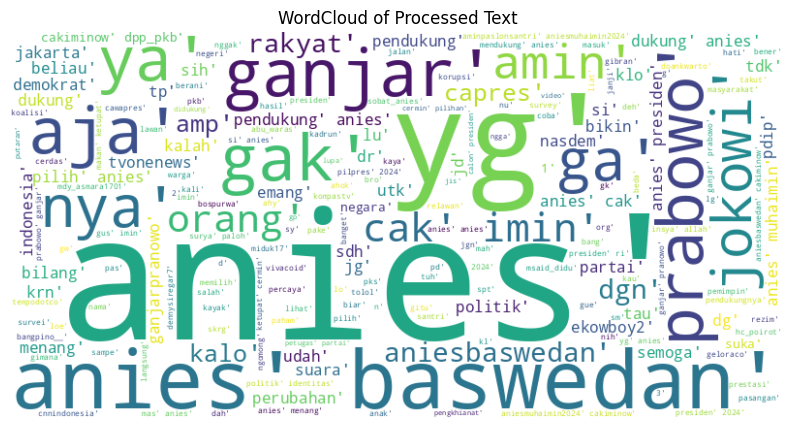

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the processed text into a single string
text_combined = ' '.join(data)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_combined)

# Display the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('WordCloud of Processed Text')
plt.show()

# Fast Text Feature Extraction

In [7]:
import fasttext.util
import numpy as np

fasttext.util.download_model('id', if_exists='ignore')
ft = fasttext.load_model('cc.id.300.bin')

data_vectors = [ft.get_sentence_vector(tweet) for tweet in data]
data_vectors = np.array(data_vectors)

# TF IDF Feature Expansion

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
data_tfidf = tfidf_vectorizer.fit_transform(data).toarray()

# Combine Fast Text and TF IDF

In [9]:
data_combined = np.concatenate([data_vectors, data_tfidf], axis=1)

# Split Data

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_combined, labels, test_size=0.2, random_state=42)

# Menangani Oversampling / Ketidakseimbangan Data

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data_combined, labels)

# CNN Model

## Melatih Model

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(data_combined.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with EarlyStopping callback and save history
history = model.fit(
    X_resampled,
    y_resampled,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
102/102 [==============================] - 3s 20ms/step - loss: 0.6939 - accuracy: 0.4879 - val_loss: 0.6915 - val_accuracy: 0.5104
Epoch 2/1000
102/102 [==============================] - 2s 17ms/step - loss: 0.6862 - accuracy: 0.5529 - val_loss: 0.6526 - val_accuracy: 0.6470
Epoch 3/1000
102/102 [==============================] - 1s 14ms/step - loss: 0.6331 - accuracy: 0.6591 - val_loss: 0.5102 - val_accuracy: 0.8028
Epoch 4/1000
102/102 [==============================] - 1s 12ms/step - loss: 0.5248 - accuracy: 0.7512 - val_loss: 0.3948 - val_accuracy: 0.8588
Epoch 5/1000
102/102 [==============================] - 1s 13ms/step - loss: 0.4166 - accuracy: 0.8147 - val_loss: 0.2844 - val_accuracy: 0.9064
Epoch 6/1000
102/102 [==============================] - 1s 13ms/step - loss: 0.3091 - accuracy: 0.8680 - val_loss: 0.1984 - val_accuracy: 0.9355
Epoch 7/1000
102/102 [==============================] - 1s 12ms/step - loss: 0.2351 - accuracy: 0.9093 - val_loss: 0.1438 - val_ac

## Visualisasi Model

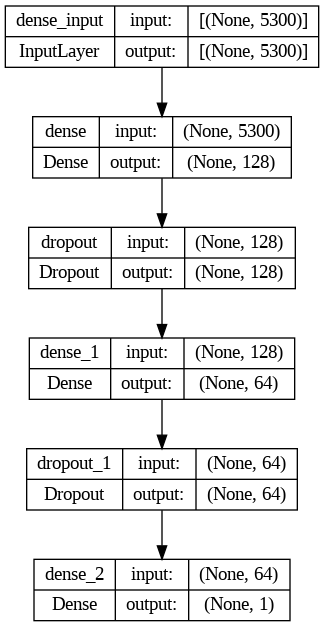

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluation

## Model Prediction vs Actual Data

Model Loss: 0.0404
Model Accuracy: 97.62%
41/41 [==============================] - 1s 8ms/step


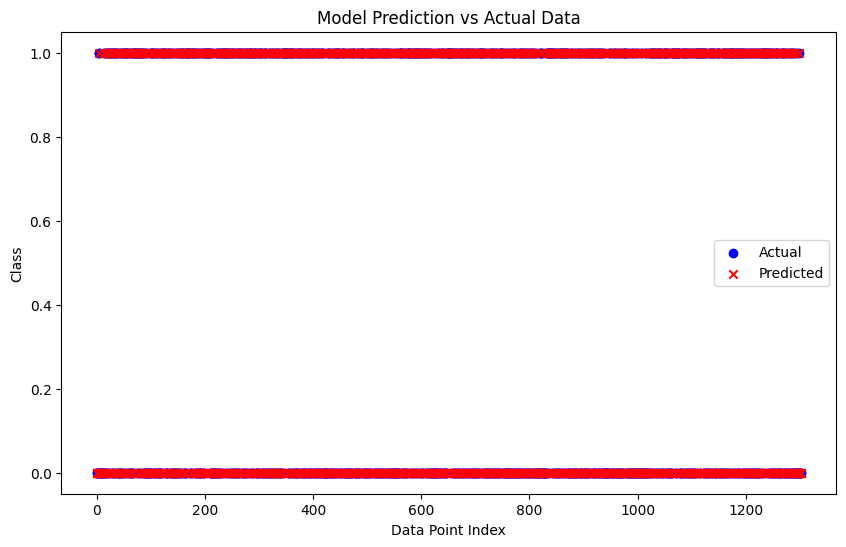

In [14]:
import matplotlib.pyplot as plt

# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Prediksi pada data test
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Plotting
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

# Plot prediksi
plt.scatter(range(len(y_pred_classes)), y_pred_classes, color='red', marker='x', label='Predicted')

plt.title('Model Prediction vs Actual Data')
plt.xlabel('Data Point Index')
plt.ylabel('Class')
plt.legend()
plt.show()

## Model Loss and Model Accuracy

Model Loss: 0.0404
Model Accuracy: 97.62%


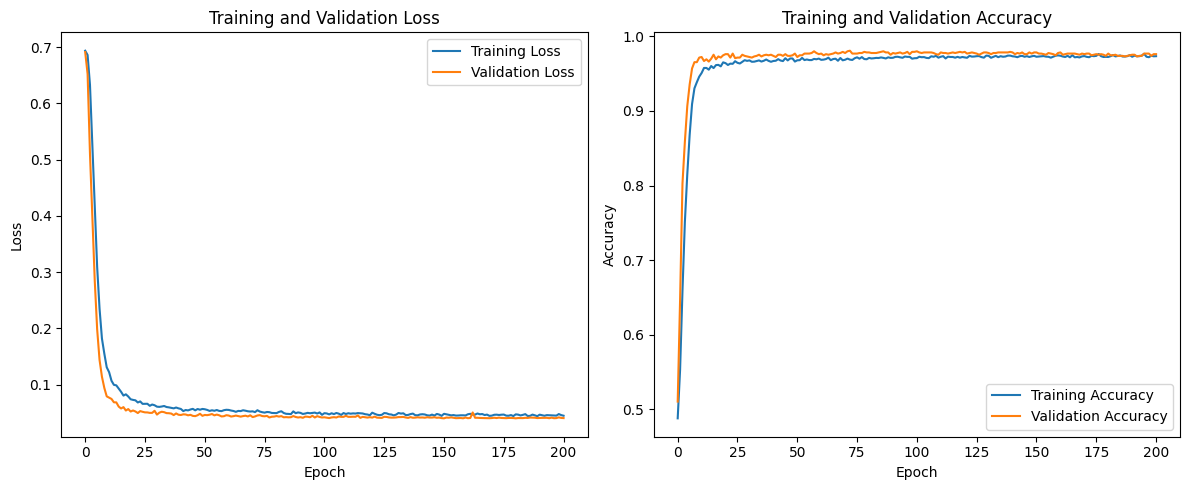

In [15]:
# Evaluasi model pada data test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Loss: {loss:.4f}")
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluating overfit or underfit
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Find the epoch with the minimum validation loss (best validation point)
best_epoch = validation_loss.index(min(validation_loss))

print(f"Best Validation Loss at Epoch {best_epoch + 1}")

# Check if the model is overfitting, underfitting, or optimal
if training_loss[best_epoch] < validation_loss[best_epoch]:
    print("Model is likely overfitting. The training loss is significantly lower than the validation loss, indicating that the model is memorizing the training data.")
elif training_loss[best_epoch] > validation_loss[best_epoch]:
    print("Model is likely underfitting. The training loss is higher than the validation loss, suggesting the model's inability to learn from the training data.")
else:
    print("Model is performing optimally or the determination is inconclusive. Both training and validation losses are close, indicating balanced performance.")

Best Validation Loss at Epoch 151
Model is likely underfitting. The training loss is higher than the validation loss, suggesting the model's inability to learn from the training data.


In [17]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.0404
Test Accuracy: 97.62%


## Accuracy, Precision, Recall

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

41/41 [==============================] - 0s 4ms/step
Accuracy: 0.9762087490406753
Precision: 0.9798761609907121
Recall: 0.9723502304147466


## Confusion Matrix

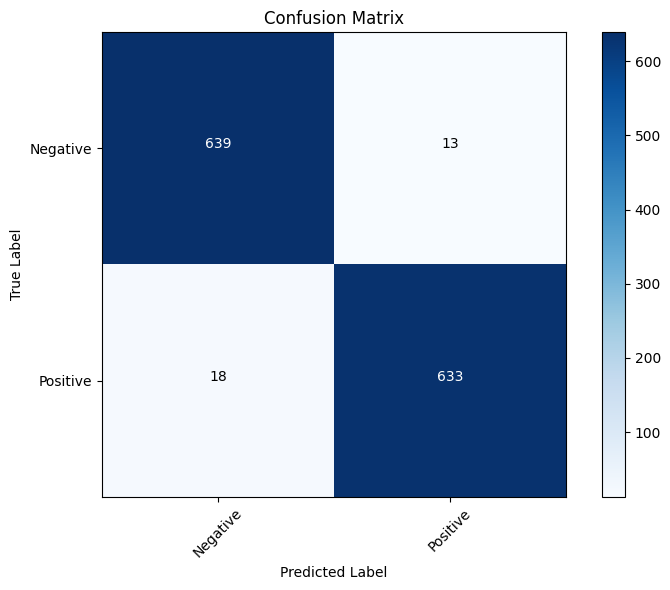

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Negative', 'Positive']))
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()